In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, shutil
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,GlobalAveragePooling2D,Flatten,Dense,Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG19

Using TensorFlow backend.


In [2]:
train_dir="dataset/seg_train"
test_dir="dataset/seg_test"
img_h = 224 #default height & width of a VGG 
img_w = 224

In [3]:
conv_vgg = VGG19(include_top=False,input_shape=(224, 224, 3),
                weights='imagenet')
conv_vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Pass the data to the VGG19 model

In [4]:
datagen = ImageDataGenerator(rescale=1./255,
            zoom_range = 0.1, # Randomly zoom image 
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True)
batch_size = 32

def predict_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count,6))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_w,img_h),
                                            batch_size = batch_size,
                                            class_mode='categorical')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_vgg.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = predict_features(train_dir, 14034) 
validation_features, validation_labels = predict_features(test_dir, 3000)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# Add the Flatten layers and Dense

In [10]:
classifier = Sequential()
classifier.add(GlobalAveragePooling2D(input_shape=(7,7,512)))

#Full Connection
#classifier.add(Dense(units = 128,activation='relu'))
classifier.add(Dense(units = 6,activation='softmax'))
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 3078      
Total params: 3,078
Trainable params: 3,078
Non-trainable params: 0
_________________________________________________________________


In [11]:
from keras.callbacks.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('model1.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='min')  

# Compile model
from keras.optimizers import Adam
classifier.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# Train model on 200 epochs

In [12]:
model = classifier.fit(train_features, train_labels,
                    epochs=150,
                    batch_size=batch_size, 
                    callbacks=[checkpoint],
                    validation_data=(validation_features, validation_labels))

Train on 14034 samples, validate on 3000 samples
Epoch 1/150
14034/14034 [==============================] - 4s 256us/step - loss: 1.0888 - accuracy: 0.6515 - val_loss: 0.8068 - val_accuracy: 0.7257

Epoch 00001: val_loss improved from inf to 0.80681, saving model to model1.h5
Epoch 2/150
14034/14034 [==============================] - 4s 254us/step - loss: 0.7153 - accuracy: 0.7566 - val_loss: 0.6683 - val_accuracy: 0.7643

Epoch 00002: val_loss improved from 0.80681 to 0.66830, saving model to model1.h5
Epoch 3/150
14034/14034 [==============================] - 4s 253us/step - loss: 0.6241 - accuracy: 0.7793 - val_loss: 0.6120 - val_accuracy: 0.7777

Epoch 00003: val_loss improved from 0.66830 to 0.61199, saving model to model1.h5
Epoch 4/150
14034/14034 [==============================] - 4s 254us/step - loss: 0.5780 - accuracy: 0.7925 - val_loss: 0.5777 - val_accuracy: 0.7893

Epoch 00004: val_loss improved from 0.61199 to 0.57769, saving model to model1.h5
Epoch 5/150
14034/14034 [==

14034/14034 [==============================] - 4s 252us/step - loss: 0.3995 - accuracy: 0.8503 - val_loss: 0.4383 - val_accuracy: 0.8357

Epoch 00037: val_loss improved from 0.44076 to 0.43831, saving model to model1.h5
Epoch 38/150
14034/14034 [==============================] - 4s 254us/step - loss: 0.3965 - accuracy: 0.8509 - val_loss: 0.4357 - val_accuracy: 0.8373

Epoch 00038: val_loss improved from 0.43831 to 0.43569, saving model to model1.h5
Epoch 39/150
14034/14034 [==============================] - 4s 253us/step - loss: 0.3943 - accuracy: 0.8529 - val_loss: 0.4359 - val_accuracy: 0.8360

Epoch 00039: val_loss did not improve from 0.43569
Epoch 40/150
14034/14034 [==============================] - 4s 252us/step - loss: 0.3942 - accuracy: 0.8518 - val_loss: 0.4351 - val_accuracy: 0.8363

Epoch 00040: val_loss improved from 0.43569 to 0.43515, saving model to model1.h5
Epoch 41/150
14034/14034 [==============================] - 4s 252us/step - loss: 0.3926 - accuracy: 0.8519 - va

14034/14034 [==============================] - 4s 253us/step - loss: 0.3638 - accuracy: 0.8634 - val_loss: 0.4224 - val_accuracy: 0.8410

Epoch 00076: val_loss did not improve from 0.42176
Epoch 77/150
14034/14034 [==============================] - 4s 253us/step - loss: 0.3630 - accuracy: 0.8661 - val_loss: 0.4211 - val_accuracy: 0.8437

Epoch 00077: val_loss improved from 0.42176 to 0.42110, saving model to model1.h5
Epoch 78/150
14034/14034 [==============================] - 4s 253us/step - loss: 0.3624 - accuracy: 0.8646 - val_loss: 0.4250 - val_accuracy: 0.8400

Epoch 00078: val_loss did not improve from 0.42110
Epoch 79/150
14034/14034 [==============================] - 4s 253us/step - loss: 0.3606 - accuracy: 0.8646 - val_loss: 0.4215 - val_accuracy: 0.8403

Epoch 00079: val_loss did not improve from 0.42110
Epoch 80/150
14034/14034 [==============================] - 4s 253us/step - loss: 0.3611 - accuracy: 0.8668 - val_loss: 0.4216 - val_accuracy: 0.8417

Epoch 00080: val_loss d


Epoch 00115: val_loss did not improve from 0.41702
Epoch 116/150
14034/14034 [==============================] - 4s 259us/step - loss: 0.3462 - accuracy: 0.8717 - val_loss: 0.4190 - val_accuracy: 0.8420

Epoch 00116: val_loss did not improve from 0.41702
Epoch 117/150
14034/14034 [==============================] - 4s 258us/step - loss: 0.3459 - accuracy: 0.8715 - val_loss: 0.4222 - val_accuracy: 0.8403

Epoch 00117: val_loss did not improve from 0.41702
Epoch 118/150
14034/14034 [==============================] - 4s 261us/step - loss: 0.3446 - accuracy: 0.8722 - val_loss: 0.4279 - val_accuracy: 0.8367

Epoch 00118: val_loss did not improve from 0.41702
Epoch 119/150
14034/14034 [==============================] - 4s 254us/step - loss: 0.3458 - accuracy: 0.8722 - val_loss: 0.4259 - val_accuracy: 0.8410

Epoch 00119: val_loss did not improve from 0.41702
Epoch 120/150
14034/14034 [==============================] - 4s 260us/step - loss: 0.3464 - accuracy: 0.8713 - val_loss: 0.4185 - val_ac

plot the data

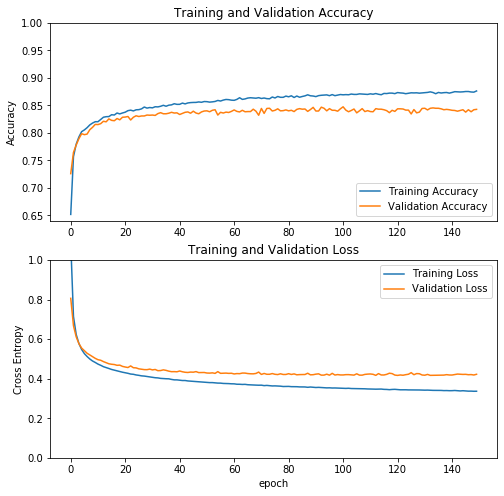

In [13]:
acc = model.history['accuracy']
val_acc = model.history['val_accuracy']

loss = model.history['loss']
val_loss = model.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()